# 03-05: Transformations and Assumptions

This notebook provides a brief reference guide for **data transformation**, specifically:
1. Why we transform data
2. How to check if you should transform (illustrative example with log transform)
3. Common transformations in social science research
4. Additional reading and reference materials

**Recommended Readings:**  
*The following chapters are available on the course website for week 9 and are highly recommended references for additional context summarized by this notebook*

- Regression and Other Stories
  - <a href="https://stat-intuitions.com/pdfs/ROS_Chap11.pdf"/>Chapter 11: Assumptions, Diagnostics, and Model Evaluation</a>  
  - <a href="https://stat-intuitions.com/pdfs/ROS_Chap12.pdf"/>Chapter 12: Transformations and Regression</a>
  - <a href="https://stat-intuitions.com/pdfs/ROS_Quick_Tips.pdf"/>10 Quick Tips to Improve your Regression Modeling</a>

## Why Transform?

You'll often be in a situation where you've collected data on different measurement scales or those that look a bit quirky when you visualize them. In these circumstances it can often be help to **transform** your data. We typically transform data for 3 primary reasons:
1. To better match the **assumptions** of our model
2. To improve **interpretation**
3. To reduce the **influence** of outliers (or rare extreme values)

### GLM Assumptions

Let's remind ourselves of the core assumption of the General-Linear-Model: **I**dependent and **I**dentitically **D**istributed errors (**i.i.d**)

This overall idea captures a few critical pieces that we've encountered in different forms:

- **Normality:** assumes that the *residuals* ($y - \hat{y}$) are normally distributed. It’s actually okay if the predictors 
 and the outcome are non-normal, so long as the residuals are normal.
- **Additivity & Linearity:** assumes that the outcome $y$ is a linear function of separate predictors $\beta_0 + \beta_1X_1 +...$
- **Homoscedasticity:** assumes that the variance of our residuals doesn't change as function of our predictors; we shouldn't be getting more or less wrong ($y - \hat{y}$) depending upon what value our predictor $X$ takes on; this matters *a lot* when we are using categorical predictors and calculating ANOVA statistics
- **Independent of errors:** assumes our residuals don't depend upon each other - this really only gets violated when you have repeated-measures, time-series, geospatial, or multi-level
- **No perfect multi-collinearity:** assumes that our predictors are just linear combinations of each other, otherwise we can figure out what the "unique variance" each one contributes to explaining $y$!

| **Assumption** | **How to Notice** | **Effect on Model** | **Example Data** |
|--------------|--------------|-----------------|-------------------|
| **Linearity** | Curved relationships in data plot | Poor model fit| Perceptual measurements, learning curves |
| **Homoscedasticity** | Residuals fan out in residual plot | Incorrect standard errors | Data with a huge range, e.g. 1-100000 | 
| **Normality of Residuals** | Skewed residuals | Invalid statistical tests | Reaction times, income |
| **Multicollinearity** | Highly correlated predictors | Inflated standard errors | Z-score Standardization | Highly correlated predictors |

<div style="text-align:center";>
<img src="./figs/violations.png" style="width:60%;">
</div>


Transformations allow us to address many of these assumption directly:

**Correcting Skewness**
- Many real-world data distributions are not symmetric.
- Reaction times, income, and neural response latencies often have a long tail (right-skewed).
- Transformations like log or square root compress the tail and make the distribution more normal-like.

**Stabilizing Variance (Homoscedasticity)**
- Ordinary Least Squares (OLS) regression assumes constant variance of residuals.
- If variance increases with magnitude (e.g., neural firing rate at different stimulus intensities), a transformation like log can help

**Making Relationships More Linear**
- OLS assumes a linear relationship between predictors and outcome.
- Some relationships are multiplicative, not additive (e.g., Weber’s Law in perception).
- Log transforms can convert these into linear trends.

**Handling Outliers**
- Large outliers have disproportionate influence in regression.
- Log and rank transforms reduce the impact of extreme values.

**Making Coefficients More Interpretable**
- Some transformations, like Z-scoring can help compare coefficients across predictors with different scales
- Others like percentage transform might be more useful to particular scientific question

## Common Transformations

Below we provide a summary table for most of the common transformation you'll encounter in Psychology, Cognitive Science, and Neuroscience research

| Transform Name  | Formula             | Meaning of Coefficient                        | What it does and when you might use it
|----------------|---------------------|-----------------------------------------------|------------------------------------------|
| Z-score      | $\frac{x - \bar{x}}{s}$ | Change in $y$ per std increase in $x$ | Makes predictors with different scales comparable and reduces multi-collinearity. Good models for models with variables on very different scales and models with interactions.
| Rank         | $\text{rank}(x) $  | Change in $y$ per unit increase in rank of $x$ | Makes it so y doesn't have to change at a constant rate per unit increase in x. Captures monotonic relationships (generally increasing/decreasing, non-linear), e.g relationship between income and happiness decreases at higher income levels |
| Log          | $\log(x)$ | % change in $y$ for a 1% increase in $x$ | Shrinks large values while keeping small values the same. Commonly use to reduce right skew (e.g. reaction times, count data). Makes multiplicative effects additive; log(a) + log(b) = a * b |
| Square Root  | $\sqrt{x}$ | Change in $y$ for a unit increase in $\sqrt{x}$ | Similar to log for reducing right skew but less extreme
| Reciprocal   | $\frac{1}{x}$ | Change in $y$ per unit change in $\frac{1}{x}$ | Similar to log but *more* extreme. Useful for rate-based data such as speed, time, and hyperbolic trends




## How to check: look for structure in your residuals!

In general, you shouldn't follow hard-and-fast rules for when to transform your data. Instead, the recommended approach by most modern practioners is to simple **evaluate your model**

We learned how to do this when we first started exploring the assumptions of our models. In particular we learned about 3 kinds of visuals we can easily make after fitting a model with `ols` to check our assumptions:

- Distribution of your residuals
  - What is the shape like? Is it normal-ish?
- Residuals vs predictor(s)
  - Is there any relationship (there shouldn't be), otherwise we have non-constant variance
- Predicted values (fits) $\hat{y}$ vs true values $y$ 
  - Is there a strong relationship? Are we predicting the dependent variable well?

### Walkthrough Example: Log Transform
Let's walk-through a brief example looking UN World Fertility Dataset:

In [1]:
import numpy as np
import polars as pl
from polars import col
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
import statsmodels.api as sm

In [2]:
df = pl.read_csv('data/fertility.csv')
df.head()

shape: (5, 8)
┌─────────────┬────────────┬────────┬───────────┬────────┬──────────┬──────────┬─────────────────┐
│             ┆ region     ┆ group  ┆ fertility ┆ ppgdp  ┆ lifeExpF ┆ pctUrban ┆ infantMortality │
│ ---         ┆ ---        ┆ ---    ┆ ---       ┆ ---    ┆ ---      ┆ ---      ┆ ---             │
│ str         ┆ str        ┆ str    ┆ f64       ┆ f64    ┆ f64      ┆ f64      ┆ f64             │
╞═════════════╪════════════╪════════╪═══════════╪════════╪══════════╪══════════╪═════════════════╡
│ Afghanistan ┆ Asia       ┆ other  ┆ 5.968     ┆ 499.0  ┆ 49.49    ┆ 23.0     ┆ 124.535         │
│ Albania     ┆ Europe     ┆ other  ┆ 1.525     ┆ 3677.2 ┆ 80.4     ┆ 53.0     ┆ 16.561          │
│ Algeria     ┆ Africa     ┆ africa ┆ 2.142     ┆ 4473.0 ┆ 75.0     ┆ 67.0     ┆ 21.458          │
│ Angola      ┆ Africa     ┆ africa ┆ 5.135     ┆ 4321.9 ┆ 53.17    ┆ 59.0     ┆ 96.191          │
│ Argentina   ┆ Latin Amer ┆ other  ┆ 2.172     ┆ 9162.1 ┆ 79.89    ┆ 93.0     ┆ 12.337          │
└─────────────┴────────────┴────────┴───────────┴────────┴──────────┴──────────┴─────────────────┘

Let's say we're interested in modeling the following relationship

$$ 
\hat{\text{infant mortality}} \sim \beta_0 + \beta_1*\text{per-capita GDP}
$$

which tests if there's a relationship the overall wealth of a country and its infant mortality rate

As always we'll start by visualizing our data and asking `seaborn` to plot a simple linear fit along with a *loess* fit, which is a simply a smooth curve that represents the fit of nearby data point.



Notice how there's clearly a relationship but it doesn't seem linear. There are way more small values for GDP than there are large ones so our regression line is limited in what it can capture using the raw data scales.

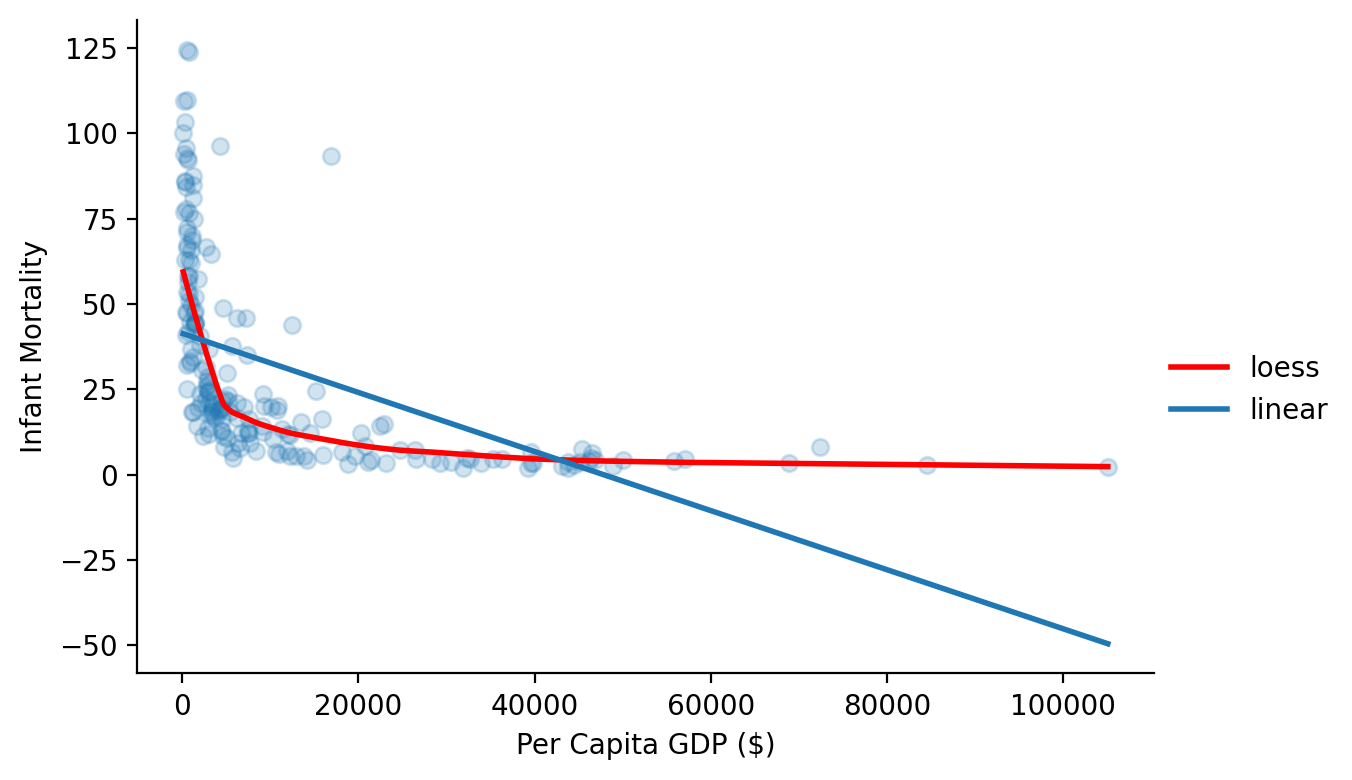

In [3]:
grid = sns.FacetGrid(data=df.to_pandas(), height=4, aspect=1.5)

grid.map(sns.regplot, 'ppgdp', 'infantMortality', lowess=True,
line_kws={'color': 'red', 'label':'loess', 'lw':2}, scatter_kws={'alpha':0.2})

grid.map(sns.regplot, 'ppgdp', 'infantMortality', ci=None, scatter_kws={'alpha': 0.0}, line_kws={'label':'linear', 'lw':2})
grid.set_axis_labels('Per Capita GDP ($)', 'Infant Mortality');


grid.add_legend();

Let's create a log transformed version of both variables and visualize the effect of the transformation. Log-transforming squishes large values while keeping small values relatively unchanged.

In [4]:
df = df.with_columns(
    col('infantMortality').log().alias('log_infantMortality'),
    col('ppgdp').log().alias('log_ppgdp')
)

Notice how the plots in the left column below show the original data with a clear right skew (long right tail). The plots in the right columnm show the log-transformed version of both variables. Notice how they look much more symmetrical and normal-ish now!

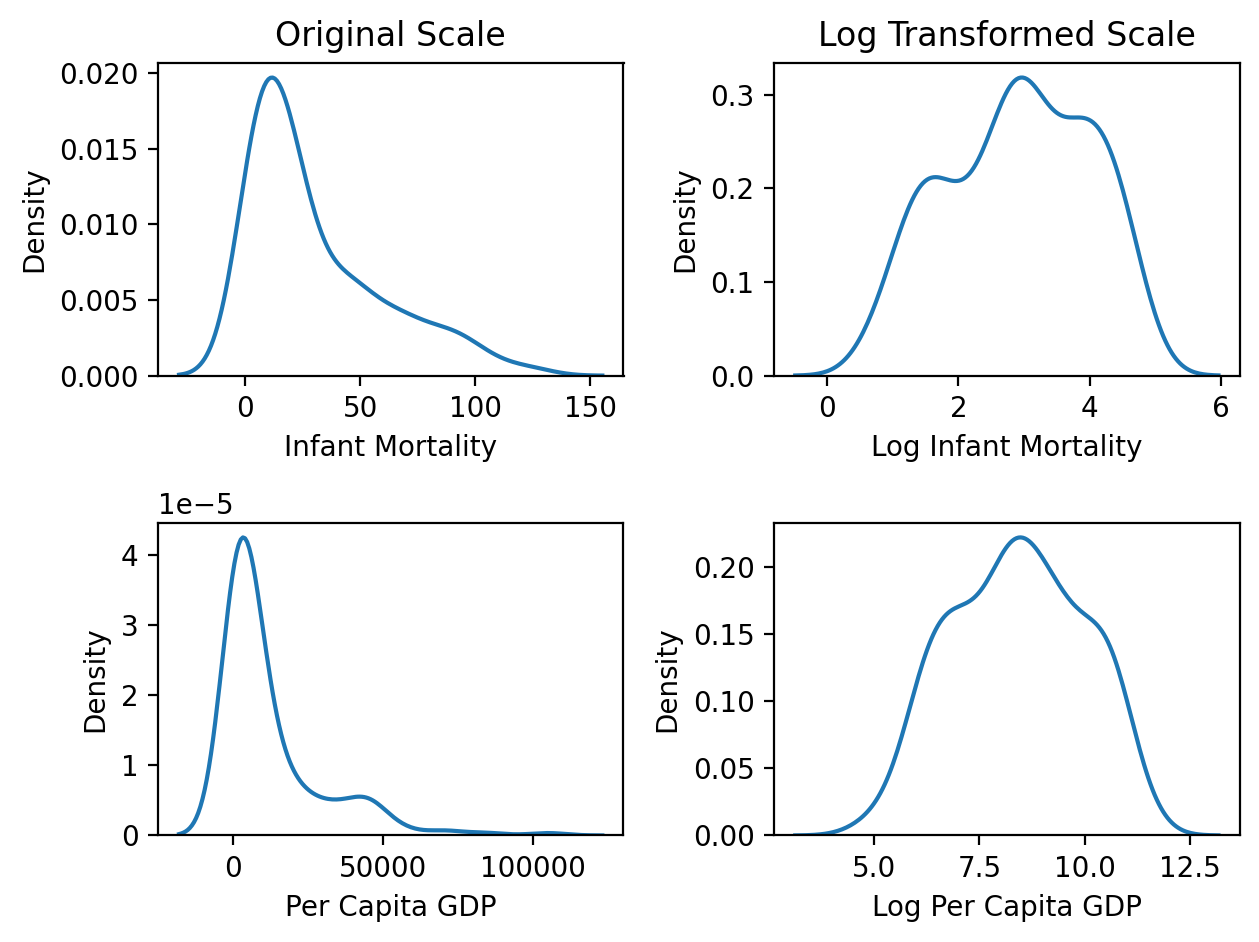

In [5]:
f, axs = plt.subplots(2,2);
ax = sns.kdeplot(data=df.to_pandas(),x='infantMortality', ax=axs[0,0]);
ax.set(xlabel='Infant Mortality', ylabel='Density', title='Original Scale');

ax =sns.kdeplot(data=df.to_pandas(),x='log_infantMortality', ax=axs[0,1]);
ax.set(xlabel='Log Infant Mortality', ylabel='Density', title='Log Transformed Scale');

ax = sns.kdeplot(data=df.to_pandas(),x='ppgdp', ax=axs[1,0]);
ax.set(xlabel='Per Capita GDP');

ax = sns.kdeplot(data=df.to_pandas(),x='log_ppgdp', ax=axs[1,1]);
ax.set(xlabel='Log Per Capita GDP');
plt.tight_layout();

In fact if we ask `seaborn` to plot the linear relationship between the log-transformed versions of both variable we can see how much better it looks!

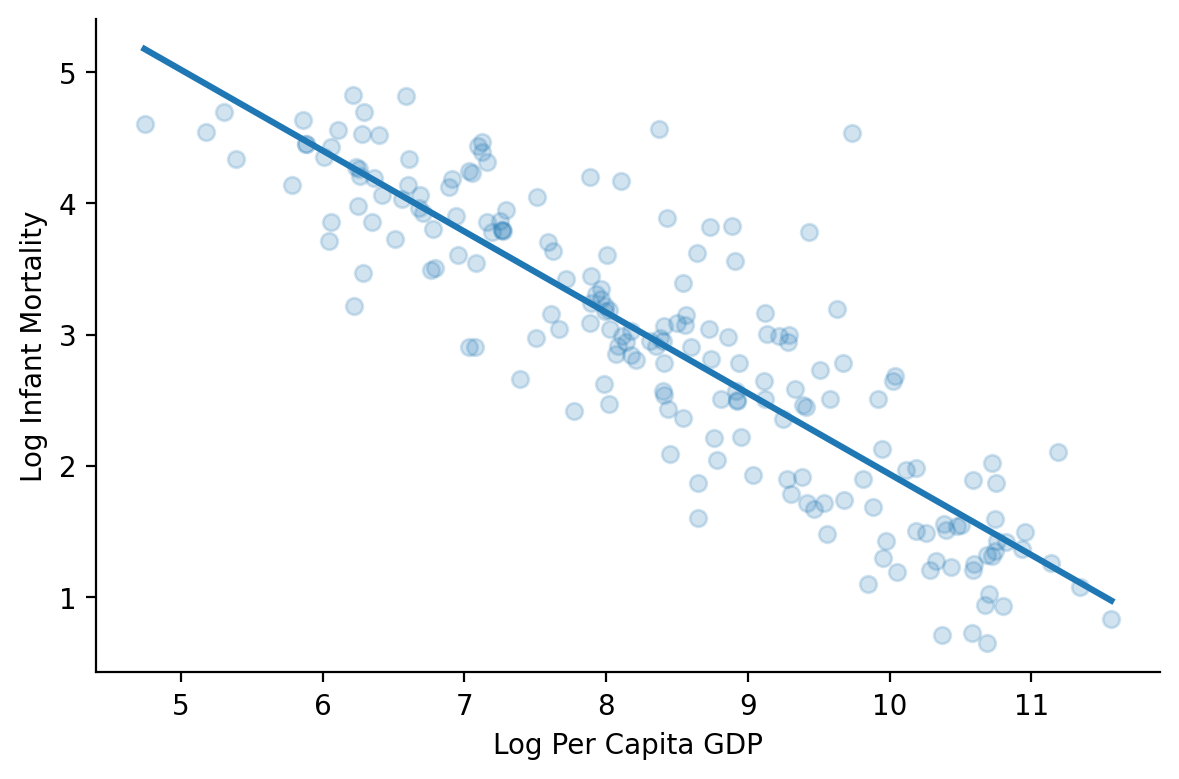

In [6]:
grid = sns.FacetGrid(data=df.to_pandas(), height=4, aspect=1.5)
grid.map(sns.regplot, 'log_ppgdp', 'log_infantMortality', scatter_kws={'alpha':0.2}, ci=None)
grid.set_axis_labels('Log Per Capita GDP', 'Log Infant Mortality');

Let's go further by fitting 2 regression models:
1. Using the original variables
2. Using the log transformed variables

Like in previous labs (and good practice), we'll store the fits and residuals from each model as new columns in our dataframe to make it easy to do some evaluation

In [7]:
lin_model = ols('infantMortality ~ ppgdp', data=df.to_pandas()).fit()
log_model = ols('log_infantMortality ~ log_ppgdp', data=df.to_pandas()).fit()

df = df.with_columns(
    linfits = lin_model.fittedvalues.to_numpy(),
    linres = lin_model.resid.to_numpy(),
    logfits = log_model.fittedvalues.to_numpy(),
    logres = log_model.resid.to_numpy()
)

#### Overall Model Fit: Predicted vs True Values

First, let's look to see how well each model fits the data overall - remember this is what our **coefficient of determination** $R_2$ is trying to capture. We'll plot the true values of $\text{infant mortality}$ against our model predictions.

Notice how the linear regression model fits the data much more poorly than the log transformed data:  

GDP only explains about 27% of the variance in infant mortality using the raw scales, but 77% of the variance when we log-transform!

We should feel much more confident in interpreting the latter model's estimates because it's doing a good job of capturing the data!

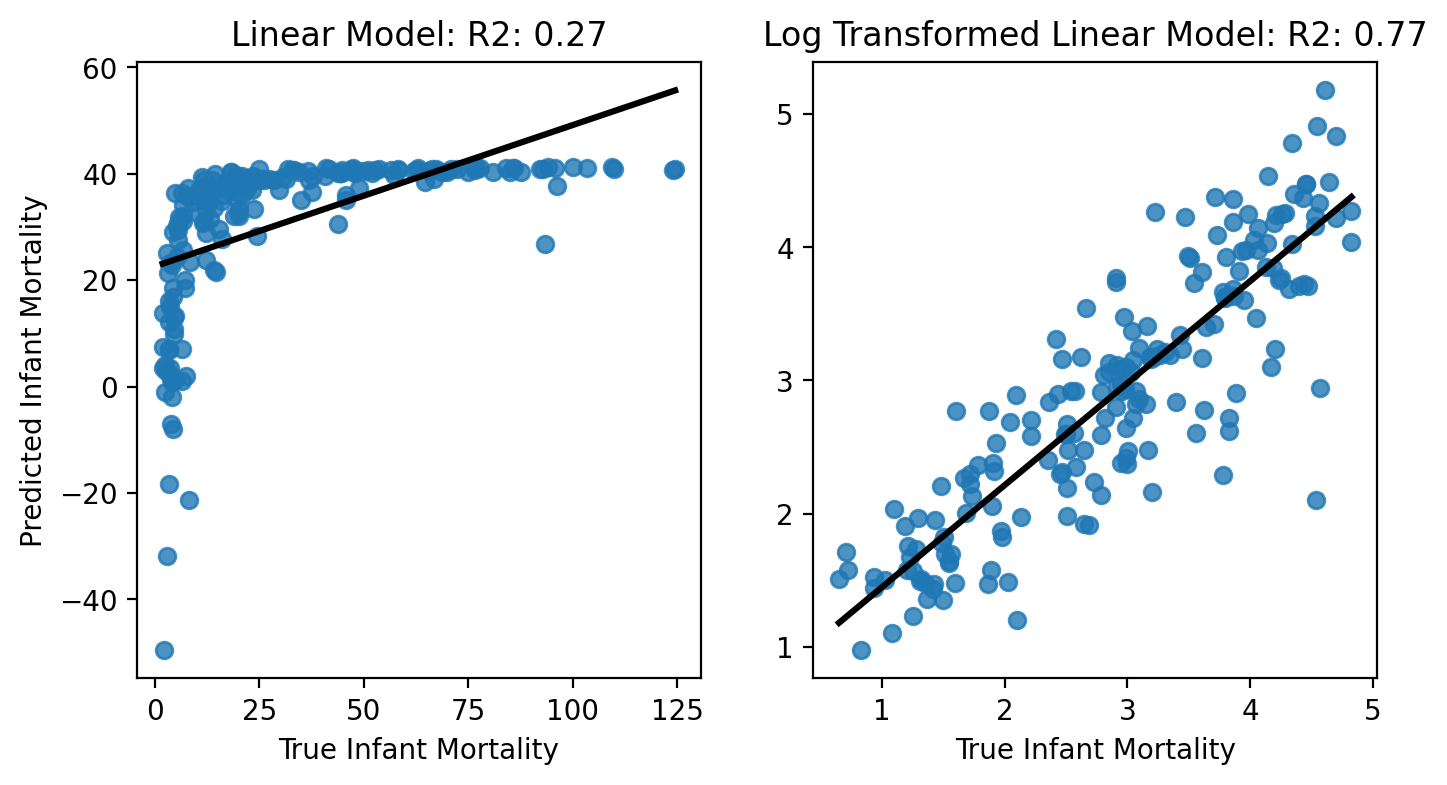

In [8]:
f, axs = plt.subplots(1,2, figsize=(8,4));

ax = sns.regplot(x='infantMortality', y='linfits', data=df.to_pandas(), ax=axs[0], ci=None, line_kws={'color':'k'});

ax.set(ylabel='Predicted Infant Mortality', xlabel='True Infant Mortality', title=f'Linear Model: R2: {lin_model.rsquared:.2f}');

ax = sns.regplot(x='log_infantMortality', y='logfits', data=df.to_pandas(), ax=axs[1], ci=None, line_kws={'color':'k'});

ax.set(ylabel='', xlabel='True Infant Mortality', title=f'Log Transformed Linear Model: R2: {log_model.rsquared:.2f}');

#### Distribution of Residuals

Ok we know the log transformed model is fitting better, but let's try to understand *why*.  
Remember we can inspect our normality assumption by checking out the distribution of the **residuals** from a model.

If we make a histogram based on each model's residuals we can see how the non-log transformed data clearly violate this assumption: the skew in our data produces a skew in our residuals! 

The log transformed residuals on the other hand, look much more normal-ish

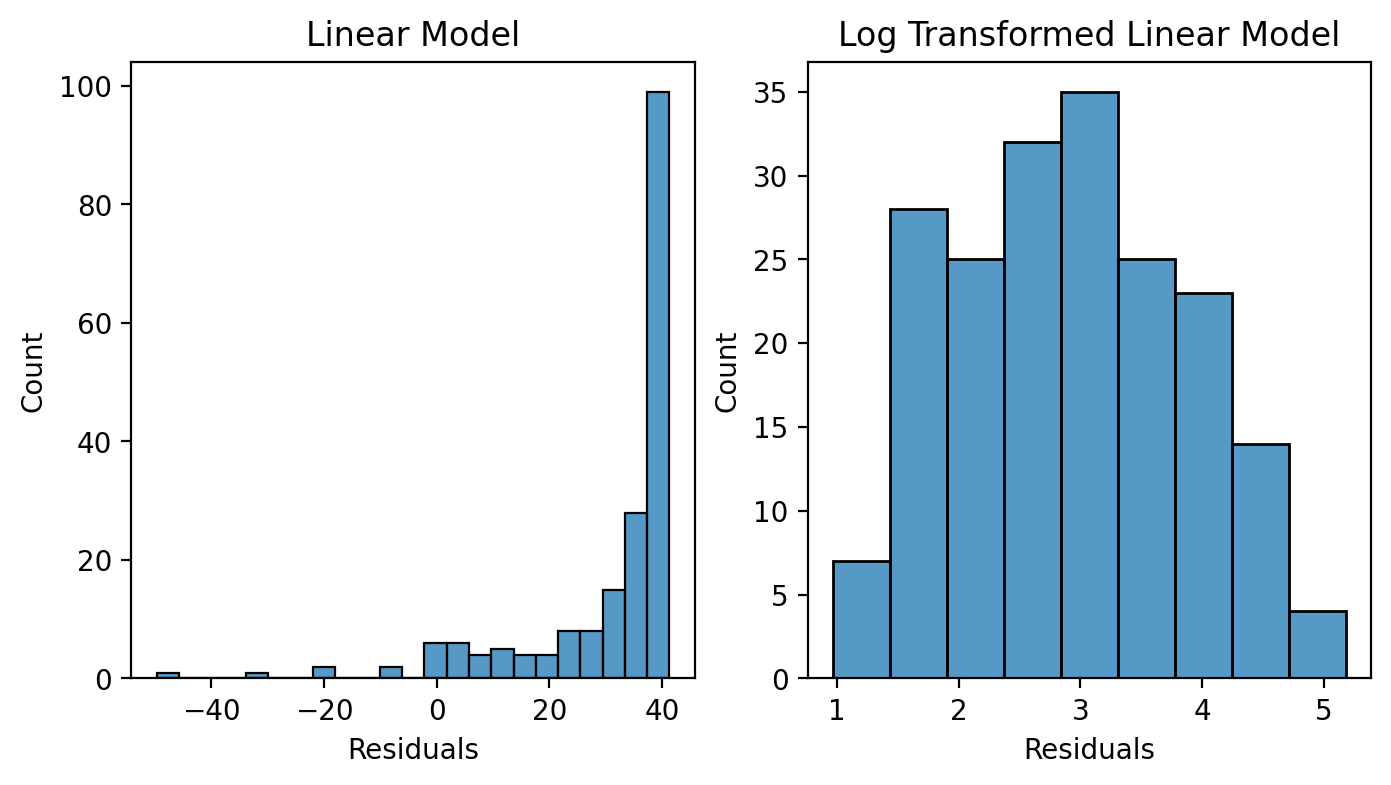

In [9]:
f, axs = plt.subplots(1,2, figsize=(8,4));

ax = sns.histplot(x='linfits', data=df.to_pandas(), ax=axs[0])
ax.set(title='Linear Model', xlabel='Residuals');
ax = sns.histplot(x='logfits', data=df.to_pandas(), ax=axs[1])
ax.set(title='Log Transformed Linear Model', xlabel='Residuals');


#### Residuals vs Predictors

Next, let's explore if there's any structure in our residuals as a function of our predictor(s). Remember there **shouldn't be** - our mis-predictions of $\text{infant mortality}$ should not depend upon the value of $GDP$ that we use to make our prediction!

We can see that our linear model's errors are the worst when $GDP$ is very high or low; at the same time there's only small range of values for where our residuals are close to 0.

Our log-transformed model on the other looks more-or-less random, which is good! We don't have any structure and therefore aren't violating the homoscedasticity assumption!

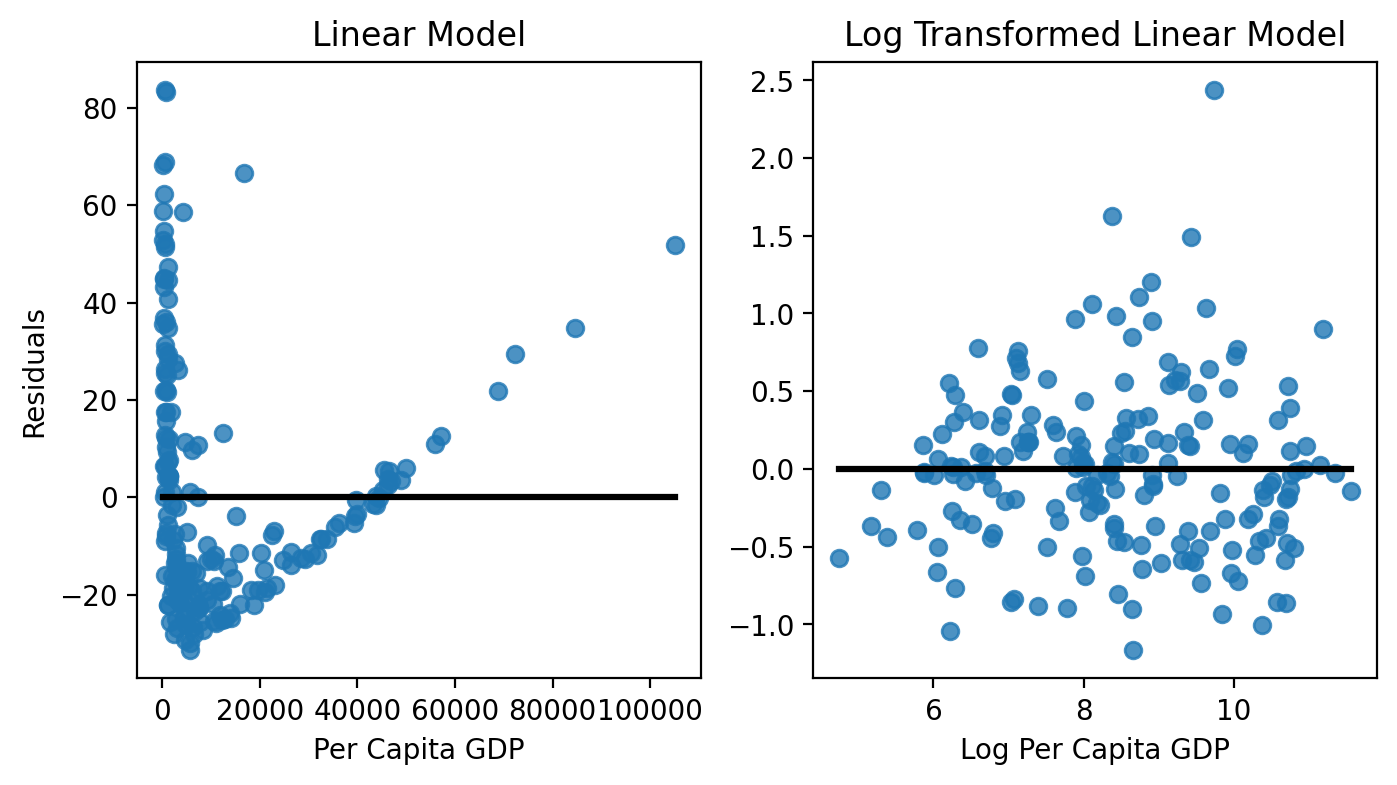

In [10]:
f, axs = plt.subplots(1,2, figsize=(8,4));

ax = sns.regplot(x='ppgdp', y='linres', data=df.to_pandas(), ax=axs[0], ci=None, line_kws={'color':'k'});

ax.set(ylabel='Residuals', xlabel='Per Capita GDP', title='Linear Model');

ax = sns.regplot(x='log_ppgdp', y='logres', data=df.to_pandas(), ax=axs[1], ci=None, line_kws={'color':'k'});

ax.set(ylabel='', xlabel='Log Per Capita GDP', title='Log Transformed Linear Model');

### Parameter Estimates

Now that we've evaluated both models, we know that we can trust the estimates from out log-transformed model because it fits the data better *and* better satisfies the assumptions of GLM.

Notice that the **last** thing we're doing is inspected our parameter estimates and inferences.

**There's no way to tell based on these values if should or should not have transformed out variables**

This is **why** we do regression diagnostics!

In [11]:
print(lin_model.summary(slim=True))

                            OLS Regression Results                            
Dep. Variable:        infantMortality   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.262
No. Observations:                 193   F-statistic:                     69.08
Covariance Type:            nonrobust   Prob (F-statistic):           1.73e-14
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     41.3780      2.216     18.675      0.000      37.008      45.748
ppgdp         -0.0009      0.000     -8.312      0.000      -0.001      -0.001

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.61e+04. This might indicate that there are
strong multicollinearity or other numerical problems.


The log transform also has a very natural interpretation: **percentages**

For each 1% increase in GDP, there is a 0.62% decrease in infant mortality

In [12]:
print(log_model.summary(slim=True))

                             OLS Regression Results                            
Dep. Variable:     log_infantMortality   R-squared:                       0.766
Model:                             OLS   Adj. R-squared:                  0.765
No. Observations:                  193   F-statistic:                     625.9
Covariance Type:             nonrobust   Prob (F-statistic):           3.51e-62
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.1038      0.211     38.430      0.000       7.688       8.520
log_ppgdp     -0.6168      0.025    -25.018      0.000      -0.665      -0.568

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.


## General Guidelines

In general we recommend thinking about the following questions when it comes to transformations:
1. Does it align with your research question and make your model more interpretable?
2. Does it better satisfy a model assumption that you're violating using the raw data?
3. Did you compare the fit and explore the residuals of the transformed and non-transformed models?

### Also relevant: How to think about outliers

Handling outliers is a tricky topic because it's very easy to convince yourself something is an outlier if it supports your hypothesis.

Instead we recommend that same inspection approach we demonstarted with the log transform walkthrough above. A great reference is [DAAMCA Chapter 13 on the course website](https://stat-intuitions.com/pdfs/DAAMCA_Ch13.pdf) which discusses a few additional statistics you can calculate to explore *which* observations are most influential on your model's fit.

Although we don't have time to cover them, statsmodels includes some [tools to calculate the influence of outliers](https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.OLSInfluence.html) that you can explore based on these [illustrative examples](https://ethanweed.github.io/pythonbook/05.04-regression.html?highlight=cook#model-checking)

## Transformations Summary

*Reproduced from [Conversion in Psychological Studies](https://psyteachr.github.io/msc-conv/)*

Most people find it difficult to accept the idea of transforming data. Tukey (1977) probably had the right idea when he called data transformation calculations “reexpressions” rather than “transformations.” A researcher is merely reexpressing what the data have to say in other terms. However, it is important to recognize that conclusions that you draw on transformed data do not always transfer neatly to the original measurements. Grissom (2000) reports that the means of transformed variables can occasionally reverse the difference of means of the original variables. While this is disturbing, and **it is important to think about the meaning of what you are doing**, but it is not, in itself, a reason to rule out the use of transformations as a viable option.

If you are willing to accept that is it permissible to transform one set of measures into another, then many possibilities become available for modifying the data to fit more closely the underlying assumptions of statistical tests. An added benefit about most of the transformations is that when we transform the data to meet one assumption, we often come closer to meeting other assumptions as well. For example, a square-root transformation may help equate group variances, and because it compresses the upper end of a distribution more than it compresses the lower end, it may also have the effect of making positively skewed distributions more nearly normal in shape. If you decide to transform, it is important to check that the variable is normally or nearly normally distributed after transformation. That is, make sure it worked.

When it comes to reporting our data… although it is legitimate and proper to run a statistical test, such as the one-way analysis of variance, on the transformed values, we often report means in the unit of the untransformed scale. This is especially true when the original units are intrinsically meaningful. Howell (2007) urges researchers to look at both the converted (transformed) and unconverted (original) means and make sure that they are telling the same basic story. Do not convert standard deviations – you will do serious injustice if you try that. And be sure to indicate to your readers what you have done. It is not uncommon to see both the converted and unconverted values reported. Tabachnick and Fidell (2007) point out that, although data transformations are recommended as a remedy for outliers and for failures of normality, linearity, and homoscedasticity, they are not universally recommended. The reason is that an analysis is interpreted from the variables that are in it, and transformed variables are sometimes harder to interpret.

You should not get the impression that data transformations should be applied routinely to all your data. As a rule of thumb, “If it’s not broken, don’t fix it.” If your data are reasonably distributed (i.e., are more or less symmetrical and have few, if any, outliers) and if your variances are reasonably homogeneous, there is probably nothing to be gained by applying a transformation. If you have markedly skewed data or heterogeneous variances, however, some form of data transformation may be useful. Furthermore, it is perfectly legitimate to shop around for a transformation that makes the necessary changes to the variance and shape. **The only thing you should not do it to try out every transformation, looking for one that gives you a significant result.** You are trying to optimize the *data*, **not your p-value.**

## Additional References
- [Data Transformation Psych Wiki](https://psychology.fandom.com/wiki/Data_transformation)
- [Older classic introduction to Transformations](http://fmwww.bc.edu/repec/bocode/t/transint.html)
- [Interpreting log transforms in a linear model](https://library.virginia.edu/data/articles/interpreting-log-transformations-in-a-linear-model)

**References**  
- Howell, D. C. (2007). Statistical methods for psychology (6th ed.). Belmont, CA: Thomson Wadsworth.
- Grissom, R. J. (2000). Heterogeneity of variance in clinical data. Journal of Consulting and Clinical Psychology, 68, 155-165.
- Tabachnick, B. G., & Fidell, L. S. (2007). Using multivariate statistics (5th ed.). Boston: Allyn and Bacon.
- Tukey, J. W. (1977). Exploratory data analysis. Reading, MA: Addison-Wesley.